# Wasserstein GAN: An Annotated Implementation
*Deep Learning Final Project*

***Authors:***
- *Alberto Mateo*
- *Anna Monso*
- *Judit*
- *Hernan Garcia Quijano*

---

## Introduction: Why Wasserstein?

[cite_start]*Generative Adversarial Networks (GANs) have demonstrated impressive results in unsupervised learning, yet they are notoriously difficult to train*[cite: 34]. [cite_start]*Standard GAN training is "delicate and unstable," often requiring a precise balance between the discriminator and generator to prevent vanishing gradients or mode collapse*[cite: 34, 53].

The paper ***"Wasserstein GAN"*** (Arjovsky et al., 2017) argues that these issues stem from the choice of distance metric used to measure the gap between the real data distribution ($\mathbb{P}_r$) and the model distribution ($\mathbb{P}_\theta$). [cite_start]*Traditional approaches, which often optimize proxies for the Kullback-Leibler (KL) or Jensen-Shannon (JS) divergences, fail when these distributions are supported by low-dimensional manifolds that do not overlap* [cite: 14-17]. [cite_start]*In these disjoint cases, the gradient often vanishes or becomes undefined, halting learning*[cite: 17, 198].

### The Solution: Earth-Mover Distance
The authors propose using the ***Earth-Mover (EM) distance*** (also known as Wasserstein-1). [cite_start]*Intuitively, if we view probability distributions as piles of earth, the EM distance is the minimum cost to transport the mass from one pile to match the other* [cite: 73-74].

[cite_start]*Unlike JS or KL divergences, the EM distance is continuous and differentiable almost everywhere, even when distributions are disjoint* [cite: 81, 112-114]. [cite_start]*This provides smooth, usable gradients for the generator throughout the training process*[cite: 124, 201].

### Key Contributions Annotated in this Project
In this notebook, we implement the ***WGAN*** algorithm to demonstrate its two primary claims:
1.  [cite_start]***A Meaningful Loss Metric:*** *We show that the WGAN critic's loss correlates with sample quality, allowing for easier debugging and hyperparameter search* [cite: 54-55, 235].
2.  [cite_start]***Improved Stability:*** *We demonstrate that WGANs are robust to architectural choices and do not require the delicate balancing of generator and discriminator capacities typical of standard GANs*[cite: 52, 342].

### 1. Setup and Configuration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Configuration based on WGAN Paper Algorithm 1
config = {
    "learning_rate": 0.00005,      # Paper uses alpha = 0.00005 
    "clip_value": 0.01,            # Clipping parameter c = 0.01 
    "batch_size": 64,              # Batch size m = 64 
    "n_critic": 5,                 # Critic iterations per generator iter = 5 
    "z_dim": 2,                    # Latent dimension (kept small for CPU visualization)
    "input_dim": 2,                # Real data dimension (2D for easy viz)
    "hidden_dim": 64,              # Small capacity for CPU speed
}


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/anna/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/anna/Library/Py

## 2. Model Architecture (Analysis & Synthesis)

This section explains the architecture of the Wasserstein GAN, breaking the model into its individual components and then synthesizing how they work together to approximate and minimize the Earth Mover distance. All explanations follow the structure of the WGAN paper.

---

#### 2.1 Analysis: Generator and Critic Architectures

##### Generator Architecture

The generator implements the mapping \( g_\theta : Z \to X \), transforming noise vectors into synthetic samples. The paper validates that simple MLPs perform well under the Wasserstein loss, even with small hidden layers.

**Diagram of the Generator**

**Analysis:** 

![Analysis Diagram](Analysis_diagram.png)


The generator implements the mapping gθ: Z → X described in Section 3 of the WGAN paper. 

In the experiments the authors validate that even simple MLPs with ReLU activations are sufficient when using the Wasserstein objective. We use a smaller version of their 4 layer MLP with 512 units, scaled down to 64 units for CPU feasibility.

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Simple MLP Generator
        self.net = nn.Sequential(
            nn.Linear(config["z_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["input_dim"]),
            # No Sigmoid here because we are generating raw data (R^2 space)
        )

    def forward(self, z):
        return self.net(z)

#### Critic Architecture:



The critic implements the function class f_w that approximates the supremum in the Kantorovich Rubinstein dual formulation of the Earth Mover distance (Section 3, equation (2)) .

The key architectural rule is that the critic outputs a real valued score and therefore does not have a sigmoid output. This is consistent with Figure 2 and Algorithm 1 in the paper.

![Critic Diagram](Critic_diagram.png)


In [3]:


class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        # Simple MLP Critic (formerly Discriminator)
        self.net = nn.Sequential(
            nn.Linear(config["input_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], 1) 
            # CRITICAL: No Sigmoid at the output! 
            # The output is a scalar score, not a probability.
        )

    def forward(self, x):
        return self.net(x)

---

#### 2.2 Enforcing the 1 Lipschitz constraint:


The WGAN critic must satisfy a 1 Lipschitz condition in order for the dual formulation of the Earth Mover distance to hold. The paper uses the Kantorovich Rubinstein duality, which expresses the Wasserstein 1 distance as

\[
W(P_r, P_\theta)
=
\sup_{f \,\text{is 1-Lipschitz}}
\left[
\mathbb{E}_{x \sim P_r}[f(x)]
-
\mathbb{E}_{x \sim P_\theta}[f(x)]
\right].
\]

Because the supremum is taken over all 1 Lipschitz functions, the critic \( f_w \) must be constrained so that its gradients do not grow without bound. WGAN enforces this constraint through **weight clipping**, which is simple, efficient, and directly follows Algorithm 1.


##### Weight Clipping

After every critic gradient update, all parameters \( w \) are projected into a fixed interval:

\[
w \leftarrow \text{clip}(w,\,-c,\,c).
\]

This forces the critic to lie in a compact subset of parameter space, which guarantees it is \( K \) Lipschitz for some constant \( K \) determined by the clipping value \( c \). Although crude, this approximation is sufficient for the dual formulation to hold and for the Wasserstein estimate to remain stable.

**Diagram**

![Lipschitz Diagram](Lipschitz_constrain_diagram.png)


---

### 2.3 Loss Functions

The Wasserstein GAN replaces the traditional GAN losses with objectives that arise directly from the dual formulation of the Earth Mover distance. Section 3 of the paper defines the critic objective in equation (3) and the generator objective in Algorithm 1.

#### Critic Loss

The critic approximates the function class required by the Kantorovich Rubinstein dual formulation. The loss it maximizes is given in equation (3) on page 7:

\[
\max_w \; \mathbb{E}_{x \sim P_r} [f_w(x)] \;-\; \mathbb{E}_{z \sim p(z)} [f_w(g_\theta(z))].
\]

When training, we convert this maximization into a minimization by negating the expression, so the critic loss becomes

\[
L_{\text{critic}} = -\left( 
\mathbb{E}_{x \sim P_r}[f_w(x)] \;-\; 
\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))]
\right).
\]

**How this is computed in code**

* The first expectation, \( \mathbb{E}_{x \sim P_r}[f_w(x)] \), is computed by passing a batch of real data through the critic and taking the mean of the critic outputs.
* The second expectation, \( \mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))] \), is computed by sampling noise vectors \(z\), generating fake samples \(g_\theta(z)\), passing those samples through the critic, and taking the mean.
* The loss is the difference between these means, with a negative sign so that gradient descent performs the maximization required by the dual formulation.

This directly matches the objective written in the paper and ensures that the critic approximates the Wasserstein distance between real and generated distributions.



#### Generator Loss

Algorithm 1 (line 10) defines the generator update step as

\[
g_\theta \leftarrow -\nabla_\theta \frac{1}{m} \sum_{i=1}^m f_w(g_\theta(z^{(i)})).
\]

This corresponds to minimizing the following generator loss:

\[
L_{\text{gen}} = - \mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
\]

**Why there are no log terms**

Traditional GANs optimize a Jensen Shannon based objective, which involves log D(x) and log(1 minus D(g(z))). WGAN removes the discriminator as a classifier and replaces it with a critic that outputs unrestricted real values. The critic no longer predicts probabilities, so there is no need for a sigmoid or logarithmic likelihood terms.

**Why the generator is not trying to fool the critic**

In a classical GAN, the generator tries to make the discriminator classify fake samples as real. In WGAN, the generator has a different role. It simply tries to reduce the critic score of its fake samples. Since the critic score approximates the Wasserstein distance, minimizing this value pushes the generated distribution closer to the real one in terms of optimal transport. There is no adversarial classification involved, only the minimization of an estimated distance.



These losses together form the core of the WGAN training dynamics. The critic estimates the Wasserstein distance and the generator minimizes that estimate, producing a stable gradient even when the support of the distributions is disjoint.


---

#### 2.4 Training loop architecture 

The WGAN training loop follows Algorithm 1 from the paper. The key idea is that the critic must be trained several times for every generator update, so it can closely approximate the supremum in the dual formulation of the Earth Mover distance. Below is a flow style reconstruction of Algorithm 1.

##### Explanation of Each Step

##### 1. ncritic critic updates

The paper sets `ncritic = 5` for most experiments. This means the critic is updated several times before each generator step.

**Sample real batch**  
A minibatch of real data \( x^{(i)} \sim P_r \) is drawn.  
The critic processes these samples to compute \( f_w(x) \).

**Sample noise batch**  
Sample \( z^{(i)} \sim p(z) \) from a simple prior (typically Gaussian or uniform).  
Pass them through the generator to obtain fake data \( g_\theta(z) \).

**Compute critic loss**  
The critic uses the loss derived from equation (3) in the paper:

\[
L_{\text{critic}} = -\left(
\mathbb{E}_{x \sim P_r}[f_w(x)] -
\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))]
\right).
\]

The critic tries to maximize the difference between scores on real and fake samples.  
We multiply by minus one so gradient descent performs this maximization.

**Update critic parameters**  
A gradient update step is applied with RMSProp, following Algorithm 1.

**Clip critic weights**  
After each update, all critic weights are clipped to lie inside \([−c, c]\).  
The paper enforces this constraint to keep the critic K Lipschitz, which is required by the Kantorovich Rubinstein dual form of the Wasserstein distance.


##### 2. One generator update

After `ncritic` critic updates, the generator is updated a single time.

**Sample noise batch**  
Draw a fresh batch \( z^{(i)} \sim p(z) \).

**Compute generator loss**

According to Algorithm 1 (line 10):

\[
L_{\text{gen}} = -\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
\]

This loss encourages the generator to produce samples that increase the critic score, which reduces the estimated Earth Mover distance between the model and real distributions.

**Update generator parameters**  
One gradient descent step is applied to the generator.  
Importantly, no clipping is applied to the generator.



##### Annotated Training Loop in Code

```python
for _ in range(num_iterations):

    # --- Critic updates ---
    for _ in range(n_critic):
        real = sample_real_batch(batch_size)
        z = sample_noise(batch_size)
        fake = generator(z).detach()  # stop gradients to generator

        critic_real = critic(real)
        critic_fake = critic(fake)

        loss_critic = -(critic_real.mean() - critic_fake.mean())

        critic_optimizer.zero_grad()
        loss_critic.backward()
        critic_optimizer.step()

        # Enforce 1-Lipschitz constraint
        for p in critic.parameters():
            p.data.clamp_(-c, c)

    # --- Generator update ---
    z = sample_noise(batch_size)
    fake = generator(z)

    loss_gen = -critic(fake).mean()

    generator_optimizer.zero_grad()
    loss_gen.backward()
    generator_optimizer.step()




---

### 2.5 Synthesis: How the Parts Come Together

The full WGAN pipeline combines the generator, critic, loss functions, and training loop into a single system that approximates and minimizes the Earth Mover distance between the real distribution \(P_r\) and the model distribution \(P_\theta\). The diagram below summarizes the flow of information through the model.


![Synthesis_diagram](Synthesis_diagram.png)


#### Unified Explanation

1. **Generator produces fake samples**  
   Noise vectors \( z \sim p(z) \) are transformed by the generator into fake data \( g_\theta(z) \).  
   These samples represent the model distribution \(P_\theta\).

2. **Critic processes both real and fake data**  
   The critic \( f_w \) outputs real valued scores for:
   * real data \( f_w(x) \)
   * fake data \( f_w(g_\theta(z)) \)

   Since the critic has no sigmoid, its output is a scalar that can freely increase or decrease to approximate the optimal Kantorovich potential.

3. **Critic estimates the Wasserstein distance**  
   The critic maximizes the expression

   \[
   \mathbb{E}_{x \sim P_r}[f_w(x)] - \mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
   \]

   This is exactly the dual form of the Earth Mover distance from equation (2) in the paper:

   \[
   W(P_r, P_\theta) = 
   \sup_{f \,\text{is 1-Lipschitz}} 
   \left( 
   \mathbb{E}_{x \sim P_r}[f(x)] 
   - \mathbb{E}_{x \sim P_\theta}[f(x)]
   \right).
   \]

   Weight clipping ensures \( f_w \) remains in a K Lipschitz function class.

4. **Critic is updated multiple times**  
   To approximate the supremum in the dual formulation, the critic is trained for `ncritic` steps before each generator update.  
   This allows it to closely estimate the Wasserstein distance.

5. **Generator is updated once per cycle**  
   After the critic is near optimal for its current parameters, the generator performs one update to minimize

   \[
   L_{\text{gen}} = -\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
   \]

   Reducing this value means reducing the critic’s estimate of the EM distance, which pushes the generated distribution toward the real one.

6. **Gradients flow through the critic into the generator**  
   Although the critic is not trained during the generator update, its gradients provide the direction in which the generator must move to decrease the Wasserstein distance.


#### How the Pipeline Implements Optimal Transport

The entire system forms a neural approximation of the optimal transport problem. The critic attempts to solve the dual formulation of the Earth Mover distance by learning a 1-Lipschitz function that best separates real and fake data. The generator then moves samples in the direction that reduces this separation.

As the training loop alternates:
* the critic estimates \( W(P_r, P_\theta) \),
* the generator minimizes that estimate.

This creates an end to end procedure in which gradient based optimization performs stochastic descent on the Wasserstein distance itself. The result is a stable learning process with meaningful, smooth gradients that do not vanish even when the real and model distributions initially lie on disjoint low dimensional manifolds.



This completes the Synthesis section and ties together all architectural and theoretical components of WGAN.



### 3. The WGAN Training Mechanics
This section implements the core mathematical contributions.Weight ClippingTo approximate the Earth Mover distance, the function must be 1-Lipschitz. The paper achieves this by clamping weights to a fixed box $[-\tilde{c}, c]$5.

In [4]:
def clip_weights(model, clip_value):
    """
    Enforce Lipschitz constraint by clipping weights.
    Paper: 'w <- clip(w, -c, c)' [cite: 190]
    """
    for p in model.parameters():
        p.data.clamp_(-clip_value, clip_value)

Initialization 

The paper notes that momentum-based optimizers like Adam can be unstable for the critic because the loss is non-stationary. They suggest RMSProp.

In [5]:
# Initialize models
G = Generator()
C = Critic()

# Use RMSProp as suggested in the paper 
# "We therefore switched to RMSProp which is known to perform well..."
optimizer_G = optim.RMSprop(G.parameters(), lr=config["learning_rate"])
optimizer_C = optim.RMSprop(C.parameters(), lr=config["learning_rate"])

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4. Minimal CPU-Ready Data (Synthetic)

To satisfy Requirement #4 (MWE), do not use heavy image datasets like LSUN. Instead, replicate Figure 2 or Example 1 from the paper: learning a simple distribution.



Here is a generator for a simple 2D Gaussian Mixture, which trains in seconds on a CPU.

In [6]:
def get_real_data(batch_size):
    """
    Generates a batch of real data: a Gaussian centered at (4, 4).
    This acts as our 'Real Distribution' P_r.
    """
    return torch.randn(batch_size, 2) + 4

### 5. The Training Loop (Annotated)
This strictly follows the loop in Algorithm 1.

Starting training...
Iter 0: Wasserstein Dist Estimate: 0.0000
Iter 200: Wasserstein Dist Estimate: 0.0074
Iter 400: Wasserstein Dist Estimate: 0.0048
Iter 600: Wasserstein Dist Estimate: 0.0026
Iter 800: Wasserstein Dist Estimate: -0.0000
Iter 1000: Wasserstein Dist Estimate: 0.0004
Iter 1200: Wasserstein Dist Estimate: 0.0002
Iter 1400: Wasserstein Dist Estimate: 0.0002
Iter 1600: Wasserstein Dist Estimate: 0.0001
Iter 1800: Wasserstein Dist Estimate: 0.0001


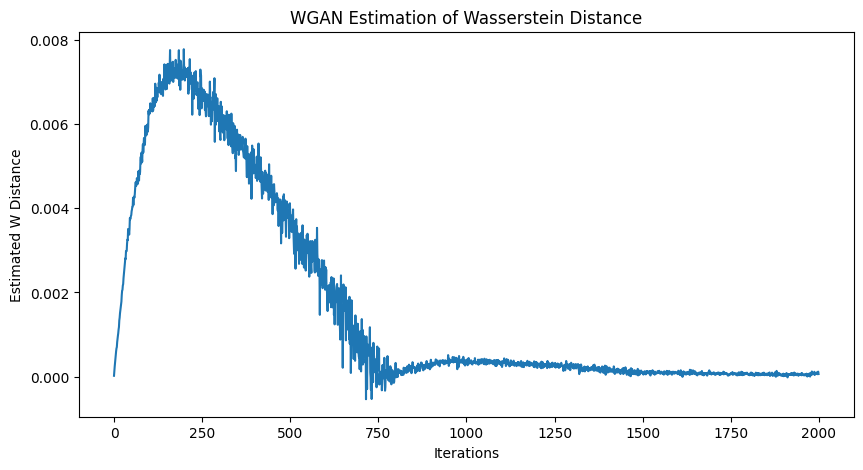

In [7]:
losses_g = []
losses_c = []
w_distances = []

print("Starting training...")

for iteration in range(2000): # Keep iterations low for MWE
    
    # ============================================
    #  1. Train the Critic (n_critic times)
    # ============================================
    for _ in range(config["n_critic"]):
        
        # Sample real data x ~ P_r [cite: 187]
        real_data = get_real_data(config["batch_size"])
        
        # Sample latent z ~ p(z) [cite: 187]
        z = torch.randn(config["batch_size"], config["z_dim"])
        fake_data = G(z).detach() # Detach so we don't backprop to G yet
        
        # Critic Loss: -(Mean(D(real)) - Mean(D(fake)))
        # We want to maximize the gap, so we minimize the negative gap.
        # See Eq (2) and Algorithm 1, Line 5 [cite: 147, 188]
        loss_c = -(torch.mean(C(real_data)) - torch.mean(C(fake_data)))
        
        optimizer_C.zero_grad()
        loss_c.backward()
        optimizer_C.step()
        
        # Clip weights to ensure Lipschitz constraint [cite: 190]
        clip_weights(C, config["clip_value"])
        
    # ============================================
    #  2. Train the Generator (1 time)
    # ============================================
    
    # Sample latent z ~ p(z) [cite: 192]
    z = torch.randn(config["batch_size"], config["z_dim"])
    
    # Generator Loss: -Mean(D(G(z)))
    # The generator wants to maximize the critic's output for its fake data.
    # See Algorithm 1, Line 10 [cite: 192]
    loss_g = -torch.mean(C(G(z)))
    
    optimizer_G.zero_grad()
    loss_g.backward()
    optimizer_G.step()
    
    # Store metrics
    losses_c.append(loss_c.item())
    losses_g.append(loss_g.item())
    # The negative critic loss approximates the Wasserstein distance
    w_distances.append(-loss_c.item())

    if iteration % 200 == 0:
        print(f"Iter {iteration}: Wasserstein Dist Estimate: {-loss_c.item():.4f}")

# Plotting the "Meaningful Loss Metric" [cite: 235]
plt.figure(figsize=(10,5))
plt.title("WGAN Estimation of Wasserstein Distance")
plt.plot(w_distances)
plt.xlabel("Iterations")
plt.ylabel("Estimated W Distance")
plt.show()

### 5. Discussion: Weaknesses/limitations/future directions.